<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/MMAI869_Pump_It_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MMAI 869, Smith School of Business at Queens University
###Team Broadview Project, Pump it Up: Data Mining the Water Table

###Import Libraries

In [ ]:
import numpy as np  
import pandas as pd  

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


### Check Allocated System Specs by Google Colab

In [ ]:
from psutil import *

cpu_count()

2

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!df -h / |awk '{print $4}'

Avail
78G


In [ ]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



###Helper Function

In [ ]:
#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)
    
     # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [ ]:
ulr_Training_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Values.csv'
ulr_Training_Set_Labels = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Labels.csv'
ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
Training_Set_Values = pd.read_csv(ulr_Training_Set_Values)
Training_Set_Labels = pd.read_csv(ulr_Training_Set_Labels)
test = pd.read_csv(ulr_Test_Set_Values)
data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

In [ ]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [ ]:
# data.isnull().sum()

In [ ]:
# test.isnull().sum()

#2- Initial Look at the Data and Preparation

In [ ]:
# data.info()

##2.1- We will go through each feature to see the values, if they are missing or have errornous values that don't make sense

* For the Na values, decided to use the most frequent value instead

In [ ]:
for i in data.columns:
  data[i].fillna(data[i].mode()[0], inplace=True)
for i in test.columns:
  test[i].fillna(test[i].mode()[0], inplace=True)
data.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

###2.1.0- FE References


https://maxhalford.github.io/blog/target-encoding/

https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64#:~:text=From%20the%20documentation%20linked%20above,over%20all%20the%20training%20data.%E2%80%9D

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/target-encoding.html

https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

https://www.kaggle.com/code/ryanholbrook/target-encoding

https://www.rasgoml.com/feature-engineering-tutorials/how-to-do-target-encoding

https://feature-engine.readthedocs.io/en/latest/

https://www.dropbox.com/sh/2vtm7k5maiyqrob/AAD7fm7Xwk6Ye9G54pgFRdFea?dl=0

https://queensu.udemy.com/course/feature-engineering-for-machine-learning/learn/lecture/9446014#overview

Target Encoding
Target encoding is a Baysian encoding technique.

Bayesian encoders use information from dependent/target variables to encode the categorical data.

In target encoding, we calculate the mean of the target variable for each category and replace the category variable with the mean value. In the case of the categorical target variables, the posterior probability of the target replaces each category.

In [ ]:
import category_encoders as ce
import pandas as pd
data=pd.DataFrame({'City':[
'Delhi','Mumbai','Hydrabad','Chennai','Bangalore','Delhi','Hydrabad','Bangalore','Delhi'
]})

#Create object for one-hot encoding
encoder=ce.OneHotEncoder(cols='City',handle_unknown='return_nan',return_df=True,use_cat_names=True)

#Original Data
data

ModuleNotFoundError: ignored

In [ ]:
#Fit and transform Data
data_encoded = encoder.fit_transform(data)
data_encoded

NameError: ignored

In [ ]:
#import the libraries
import pandas as pd
import category_encoders as ce

#Create the Dataframe
data=pd.DataFrame({'class':['A,','B','C','B','C','A','A','A'],'Marks':[50,30,70,80,45,97,80,68]})

#Create target encoding object
encoder=ce.TargetEncoder(cols='class') 

#Original Data
Data

In [ ]:
#Fit and Transform Train Data
encoder.fit_transform(data['class'],data['Marks'])

###2.1.1- amount_tsh
Total static head (amount water available to waterpoint)

https://inspectapedia.com/water/Well_Static_Head_Definition.php

The static head volume inside a water well tells us how much water is available to the pump after the well has rested, water has risen to its maximum height inside the well, and the pump is about to turn on.

* Depending on the unit of measurment for volume, some values might not make sense, we don't have the unit here
* We have 41639 values of zero, need to replace them with some representative number with assumption, i.e. mean of other values. I will consider only the values that are not occuring only once, just an auumption
* Need to remove outliers as well, lets decide which one is considered as outlier. Left them to be for now

In [ ]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
data.amount_tsh.value_counts().sort_values(ascending=False)

0.00        41639
500.00       3102
50.00        2472
1000.00      1488
20.00        1463
            ...  
0.25            1
12.00           1
60000.00        1
306.00          1
59.00           1
Name: amount_tsh, Length: 98, dtype: int64

In [ ]:
# data[data['amount_tsh'].map(data['amount_tsh'].value_counts() > 1)]

In [ ]:
tsh_multiple_occurance_df = data.groupby('amount_tsh').filter(lambda x: len(x) > 1)
tsh_multiple_nonzero_occurance_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh>0]
tsh_multiple_nonzero_occurance_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
11,50409,200.0,2013-02-18,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
16,48451,500.0,2011-07-04,Unicef,1703,DWE,34.642439,-9.106185,Kwa John Mtenzi,0,...,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,non functional


In [ ]:
tsh_zero_value_df = tsh_multiple_occurance_df[tsh_multiple_occurance_df.amount_tsh==0]
zero_tsh_index = tsh_zero_value_df.id.tolist()
data.loc[data['id'].isin(zero_tsh_index), 'amount_tsh'] = round(tsh_multiple_nonzero_occurance_df.amount_tsh.mean())

In [ ]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,984.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,984.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,984.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


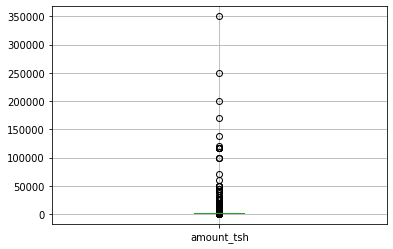

In [ ]:
boxplot = data.boxplot(column=['amount_tsh'])

###2.1.2. date_recorded
The date the row was entered
* Date recorded does not add much value by itself, we might only need the year. So, only the year row was entere is keeped. The other info of the feature can be used to find the day of the week, month, season, etc. of row recorded. The season might add some vale since it can be rainy or dry season in Tanzania. We will extract the season by percipitation amounts and add it as a new feature to the dataset. 
*Percipitation amount around the date the row was recorded can be valuable info, percipitation_amount above 100mm is assumed "high" and lower than 100mm assumed "low", indicating rainy and dry seasons. 

In [ ]:
data.date_recorded = data.date_recorded.str.replace('-','')
data.date_recorded = data.date_recorded.str[:4]
data.date_recorded = data.date_recorded.astype(int)

AttributeError: ignored

In [ ]:
test.date_recorded = test.date_recorded.str.replace('-','')
test.date_recorded = test.date_recorded.str[:4]
test.date_recorded = test.date_recorded.astype(int)

AttributeError: ignored

In [ ]:
data.date_recorded.head()

###2.1.3- construction_year
Year the waterpoint was constructed. this feature has so many 0 values that does not make sense. We will replace them with mode of that feature. This might not be a good idea so we should consider another replacement after.
* we can calculate the age of the well at the date of recording the row.

In [ ]:
data.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [ ]:
construction_year_zero_index = data[data.construction_year==0].id.tolist()
data.loc[data['id'].isin(construction_year_zero_index), 'construction_year']= np.NaN
data['construction_year'].fillna(data['construction_year'].mode()[0], inplace=True)

###2.1.4- Other features
for all other features we need to do a sanity check, just to see if nothing unexpected has happened, one might put none as a categorical input, need to treat it as Na. Scan all features for any unexpected errors

* wpt_name has many 'none' values,need to change them to NaN and replace them with mode of that feature.
* recorded_by is all done by one team, no value is coming form this feature. Need to drop it from the dataset.
* num_private, This feature is mostly missing, so we will drop it from dataset. 98% of the num_private feature has value of zero, so we drop it from our dataset.
* scheme_management has one 'none' value, we will replace it with the other cateory.
* scheme_name has also 'None' values, which we will replace with the mode of that feature.


In [ ]:
data.wpt_name.value_counts()

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

In [ ]:
wpt_name_none_index = data[data.wpt_name=='none'].id.tolist()
data.loc[data['id'].isin(wpt_name_none_index), 'wpt_name']= np.NaN
data['wpt_name'].fillna(data['wpt_name'].mode()[0], inplace=True)
# data.head()

In [ ]:
data.recorded_by.value_counts()


GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [ ]:
data.num_private.value_counts()

0       58643
6          81
1          73
5          46
8          46
        ...  
42          1
23          1
136         1
698         1
1402        1
Name: num_private, Length: 65, dtype: int64

In [ ]:
data = data.drop(['num_private'], axis=1)
data = data.drop(['recorded_by'], axis=1)

In [ ]:
data.scheme_management.value_counts()


VWC                 40670
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [ ]:
scheme_management_none_index = data[data.scheme_management=='None'].id.tolist()
data.loc[data['id'].isin(scheme_management_none_index), 'scheme_management']= 'Other'

In [ ]:
data.scheme_name.value_counts()

K                       28848
None                      644
Borehole                  546
Chalinze wate             405
M                         400
                        ...  
Mradi wa maji Vijini        1
Villagers                   1
Magundi water supply        1
Saadani Chumv               1
Mtawanya                    1
Name: scheme_name, Length: 2696, dtype: int64

In [ ]:
scheme_name_none_index = data[data.scheme_name=='None'].id.tolist()
data.loc[data['id'].isin(scheme_name_none_index), 'scheme_name']= np.NaN
data['scheme_name'].fillna(data['scheme_name'].mode()[0], inplace=True)

In [ ]:
data.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [ ]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011,Roman,1390,Roman,34.938093,-9.856322,Shuleni,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,984.0,2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,984.0,2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,984.0,2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


##2.2- Encoding the Object Features and Labels

###2.2.1- Label Distribution
Multiclass Classification Labels, need to encode them

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

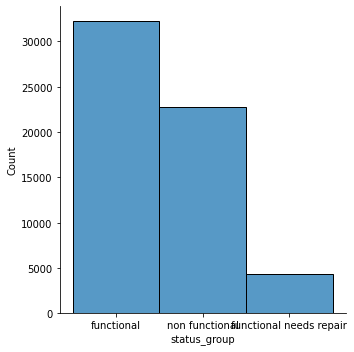

In [ ]:
sns.displot(data.status_group)

In [ ]:
data.status_group.value_counts()


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [ ]:
data.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [ ]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

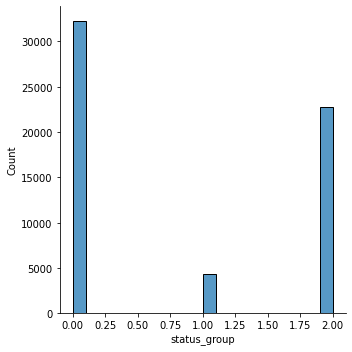

In [ ]:
sns.displot(data.status_group)

In [ ]:
# data.info()

###2.2.2- Object features encoding
* All the categorical features need to be encoded, used OrdinalEncoder

References: 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

https://datascience.stackexchange.com/questions/98137/separate-numerical-and-categorical-variables

In [ ]:
ordinal_encoder = OrdinalEncoder()

In [ ]:
# target_encoder = 

In [ ]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [ ]:
for i in df_categorical_features.columns:
  data[i] = ordinal_encoder.fit_transform(data[i].values.reshape(-1,1))

In [ ]:
for i in df_categorical_features.columns:
  test[i] = ordinal_encoder.fit_transform(test[i].values.reshape(-1,1))

In [ ]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011,1369.0,1390,1518.0,34.938093,-9.856322,35529.0,1.0,...,6.0,2.0,1.0,1.0,8.0,6.0,0.0,1.0,1.0,0
1,8776,984.0,2013,469.0,1399,545.0,34.698766,-2.147466,37195.0,4.0,...,6.0,2.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0,0
2,34310,25.0,2013,825.0,686,2048.0,37.460664,-3.821329,14572.0,5.0,...,6.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0
3,67743,984.0,2013,1741.0,263,1852.0,38.486161,-11.155298,37285.0,7.0,...,6.0,2.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,2
4,19728,984.0,2011,20.0,0,119.0,31.130847,-1.825359,35529.0,4.0,...,6.0,2.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,0


Correlation Matrix

In [ ]:
# plt.figure(figsize=(10,8))
# cmap=data.corr()
# sns.heatmap(cmap)

#3- Train and Test Split

In [ ]:
X = data.drop(['id', 'status_group'],axis=1)
Y = data.status_group
x_test=test.drop('id',axis=1)

In [ ]:
# data.head()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, random_state = 0, test_size = 0.1, stratify = Y, shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((53460, 37), (5940, 37), (53460,), (5940,))

###3.1- Transforming features

The classes are imbalanced, used balanced parameter 

In [ ]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
# x_test = scaler.transform(x_test) # The final test set

In [ ]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)

class_weights = dict(zip(np.unique(y_train),class_weights))
class_weights 

# class_weights = dict(zip(np.unique(x_train), class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

{0: 0.6137843144008542, 1: 4.586872586872587, 2: 0.8674909940609483}

In [ ]:
# sns.displot(y_val)

In [ ]:
y_valid.value_counts()

0    3226
2    2282
1     432
Name: status_group, dtype: int64

#4- Building Models

##4.1- Logistic regression

####Fit the Logistic regression model and Tune Hyperparameter

In [ ]:
lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(x_train, y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

* Hyperparameter Tuning

In [ ]:
params = {
    'alpha' : [0.001, 0.01, 0.1, 1.0, 10]
}
lr_hyperparam = GridSearchCV(lr_sgd, params, scoring='f1', cv=3, n_jobs = -1, verbose = 5, return_train_score = True)
lr_hyperparam.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='elasticnet',
                                     random_state=42),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10]},
             return_train_score=True, scoring='f1', verbose=5)

In [ ]:
lr_hyperparam.best_params_

{'alpha': 0.001}

In [ ]:
lr_full = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_full.fit(x_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

####Perform Prediction and Display Results for Logistic regression




In [ ]:
lr_preds = lr_full.predict(x_valid)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      3226
           1       0.25      0.25      0.25       432
           2       0.62      0.57      0.59      2282

    accuracy                           0.62      5940
   macro avg       0.52      0.51      0.51      5940
weighted avg       0.62      0.62      0.62      5940



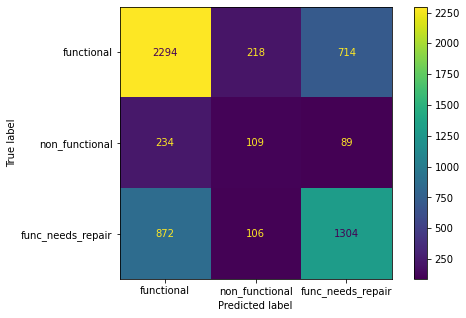

In [ ]:
print(classification_report(y_valid, lr_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, lr_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
lr_table = PrettyTable()
lr_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

lr_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_valid, y_pred = lr_preds),
    f1_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = lr_preds)
])
print(lr_table)

+---------------------+--------------------+--------------------+--------------------+--------------------+
|      Model Name     |      Accuracy      |      F1-Score      |     Precision      |       Recall       |
+---------------------+--------------------+--------------------+--------------------+--------------------+
| Logistic Regression | 0.6240740740740741 | 0.6226644342678842 | 0.6225008572743271 | 0.6240740740740741 |
+---------------------+--------------------+--------------------+--------------------+--------------------+


####Feature Importances - Logistic Regression

<ipython-input-9-98f99d594e09>:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
<ipython-input-9-98f99d594e09>:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


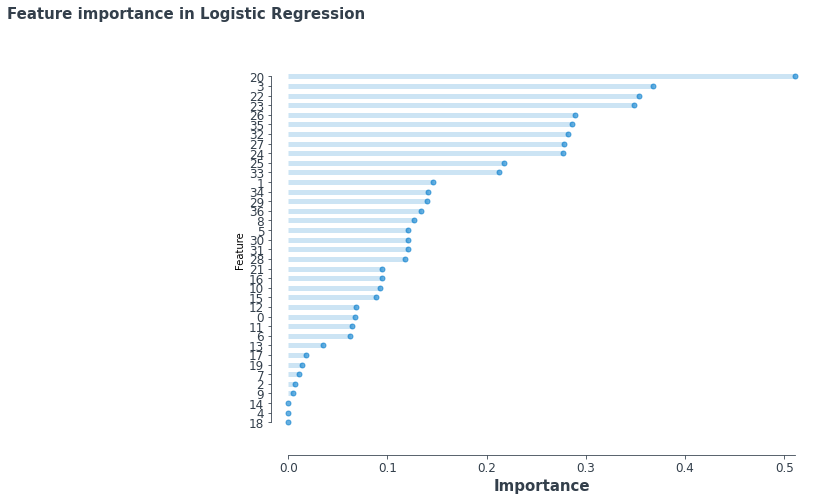

In [ ]:
pretty_importances_plot(
    np.abs(lr_full.coef_[0]), 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)

##4.4- ADABoostClassifier
The training algorithm involves starting with one decision tree, finding those examples in the training dataset that were misclassified, and adding more weight to those examples. Another tree is trained on the same data, although now weighted by the misclassification errors. This process is repeated until a desired number of trees are added.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

https://www.datacamp.com/tutorial/adaboost-classifier-python#adaboost-classifier

https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

https://vitalflux.com/differences-between-random-forest-vs-adaboost/

https://vitalflux.com/adaboost-algorithm-explained-with-python-example/#:~:text=Base%20estimators%20for%20Adaboost%20algorithm,in%20classifier%20with%20high%20variance.

https://techfor-today.com/hyperparameter-tuning-of-adaboost/

###4.4.1- Hyper Parameter Tuning for AdaBoosting - Sequential Approach

####4.4.1.1- The optimum number of trees in Adaboost
Create a function that will build various Ada boost models. And for the model, we will specify a different number of decision stumps starting from 50 to 1000.

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    Ada_models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = AdaBoostClassifier(n_estimators=i, random_state=7)
    return models

The next step is to build a function for the validation of the models. In this case, we will use the cross-validation method. Let us build the function which returns the accuracy score of the models.

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1, random_state=7)
    
#      accuracy score- hyperparameter tuning of Adaboost
    return accuracy

Now, we will call the above functions which will create the models and will evaluate them based on the accuracy score.

In [ ]:
# calling the build_models function
models = {}
models = build_models()

# creating list
results, names = list(), list()

# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

---->Stump tree (10)---Accuracy( 0.70557)
---->Stump tree (50)---Accuracy( 0.72437)
---->Stump tree (100)---Accuracy( 0.73070)
---->Stump tree (500)---Accuracy( 0.74459)


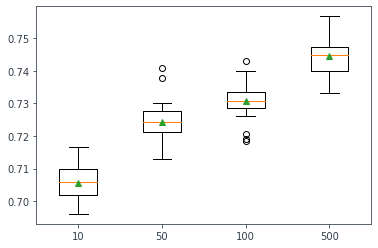

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Tunning the weak learner in Ada boost - max_depth
A decision tree with one level is used as a weak learner by default in the Ada boost. We can increase the depth of the stump tree to get the optimum depth tree.

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,8):
        
        # model
        base_model = DecisionTreeClassifier(max_depth=i, random_state=7)
        
        # creating dic of modles
        models[str(i)] = AdaBoostClassifier(base_estimator=base_model, random_state=7)
        
#   returining the model -results of hyperparameter tuning of Adaboost
    return models

In this section, we will not again build the evaluation function, as we have already created in the above section. So, we can use it here as well.

In [ ]:
# calling the function
models={}
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Stump tree (1)---Accuracy( 0.72301)
---->Stump tree (2)---Accuracy( 0.73909)
---->Stump tree (3)---Accuracy( 0.74643)
---->Stump tree (4)---Accuracy( 0.74865)
---->Stump tree (5)---Accuracy( 0.74395)
---->Stump tree (6)---Accuracy( 0.73227)
---->Stump tree (7)---Accuracy( 0.72250)


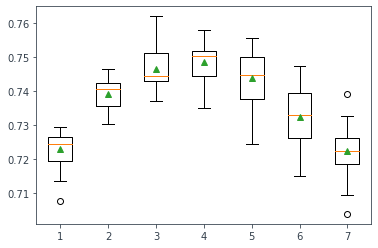

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Tuning learning rate in Ada boost
Learning rate is simply the step size of each iteration. The default value of the learning rate in the Ada boost is 1. We will now use the hyperparameter tuning method to find the optimum learning rate for our model.

In [ ]:
# building the models
def build_models():
    
#     creating the model dic
    models = dict()
    
    
    # learning rate for various values
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.3f' % i
        
#         models in dic
        models[key] = AdaBoostClassifier(learning_rate=i, random_state=7)
    
#     returning models -results of hyperparameter tuning of Adaboost
    return models

In [ ]:
# calling the function
models={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Stump tree (0.100)---Accuracy( 0.69991)
---->Stump tree (0.200)---Accuracy( 0.70763)
---->Stump tree (0.300)---Accuracy( 0.71405)
---->Stump tree (0.400)---Accuracy( 0.71653)
---->Stump tree (0.500)---Accuracy( 0.71975)
---->Stump tree (0.600)---Accuracy( 0.72191)
---->Stump tree (0.700)---Accuracy( 0.72185)
---->Stump tree (0.800)---Accuracy( 0.72164)
---->Stump tree (0.900)---Accuracy( 0.72358)
---->Stump tree (1.000)---Accuracy( 0.72339)
---->Stump tree (1.100)---Accuracy( 0.72530)
---->Stump tree (1.200)---Accuracy( 0.72401)
---->Stump tree (1.300)---Accuracy( 0.72042)
---->Stump tree (1.400)---Accuracy( 0.72207)
---->Stump tree (1.500)---Accuracy( 0.72088)
---->Stump tree (1.600)---Accuracy( 0.71616)
---->Stump tree (1.700)---Accuracy( 0.71467)
---->Stump tree (1.800)---Accuracy( 0.70706)
---->Stump tree (1.900)---Accuracy( 0.69547)
---->Stump tree (2.000)---Accuracy( 0.51683)


In [ ]:
# fixing the size
plt.figure(figsize=(10, 8))
# plotting the values
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

###4.4.2- Hyper Parameter Tuning for AdaBoosting - gridSearchCV Approach
In the second aproach, we will use the GridSearchCV method to find the optimum values for the parameters of the Ada boost algorithm using the same dataset. GridSearchCV takes every possible value ( specified ones) and train the model on the different combination and returns the optimum values.

In [ ]:
# defining the classifier
model = AdaBoostClassifier()
# creating a dic for the grid
grid = dict()
# estimator till 500
grid['n_estimators'] = [100, 200, 500]
# defining learning rate
grid['learning_rate'] = [1.0, 1.1, 1.2]
# defining the CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)
# initializing the grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# training the model on grid search for hyperparameter tuning of Adaboost
grid_result = grid_search.fit(x_train, y_train)
# finding the best results /hyperparameter tuning of Adaboost
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

KeyboardInterrupt: ignored

###4.4.3- Fitting the Optimum Model

In [ ]:
dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=1, random_state=7)

In [ ]:
AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 500,
                                  learning_rate=1,
                                  algorithm='SAMME.R',
                                  random_state=7)

In [ ]:
AdaBoost_model = AdaBoost_clf.fit(x_train, y_train)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)

In [ ]:
n_scores = cross_val_score(AdaBoost_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.745 (0.005)


In [ ]:
AdaBoost_pred = AdaBoost_model.predict(x_valid)

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      3226
           1       0.44      0.08      0.14       432
           2       0.78      0.63      0.70      2282

    accuracy                           0.73      5940
   macro avg       0.65      0.54      0.55      5940
weighted avg       0.72      0.73      0.71      5940



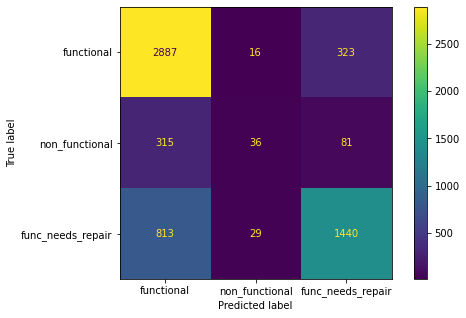

In [ ]:
print(classification_report(y_valid, AdaBoost_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, AdaBoost_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
model = AdaBoostClassifier(base_estimator = RandomForestClassifier(n_estimators = 2000, random_state = 1, class_weight = class_weights)).fit(x_train,y_train)

##4.3- Gradient Boosting
Gradient Tree Boosting, Stochastic Gradient Boosting, and GBM are other names for the Gradient Boosting Algorithm. It creates a sequence of weak models ( usually decision trees) and comes up with a final strong learner. Each prediction in gradient boosting aims to outperform the one before it by lowering the errors. Gradient Boosting’s key principle is that it fits a new predictor to the residual errors created by the preceding predictor rather than fitting a prediction to the data at each iteration.

https://techfor-today.com/gradient-boosting-algorithm-using-python/



###4.3.1- Hyper Parameter Tuning for Gradient Boosting

GradientBoostingClassifier(*, loss: str = "deviance", learning_rate: float = 0.1, n_estimators: int = 100, subsample: float = 1, criterion: str = "friedman_mse", min_samples_split: int = 2, min_samples_leaf: int = 1, min_weight_fraction_leaf: float = 0, max_depth: int = 3, min_impurity_decrease: float = 0, init: Any | None = None, random_state: Any | None = None, max_features: Any | None = None, verbose: int = 0, max_leaf_nodes: Any | None = None, warm_start: bool = False, validation_fraction: float = 0.1, n_iter_no_change: Any | None = None, tol: float = 0.0001, ccp_alpha: float = 0)

####4.3.1.1- Finding the optimum number of trees in Gradient boosting

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    GB_models = dict()
    
    # number of decision stumps
    decision_stump= [150, 200, 250, 300]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        GB_models[str(i)] = GradientBoostingClassifier(n_estimators=i)
    
#     returning the model
    return GB_models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing - Gradient boosting algorithm using Python
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

---->Iterations (150)---Accuracy( 0.76208)


KeyboardInterrupt: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.2- Finding the optimum depth of trees in the Gradient boosting algorithm using Python

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     specifying the depth of trees
    for i in range(1,7):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_depth=i)
        
#   returining the model
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Gradient boosting algorithm using Python
    print('---->Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

NameError: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding an optimum Learning rate in Gradient boosting algorithm using Python

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     different learning rates
    for i in [0.05, 0.1, 0.2, 0.5, 1.0, 1.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        GB_models[k] = GradientBoostingClassifier(learning_rate=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing learning rate of Gradient boosting algorithm using Python
    print('---->Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding an optimum number of features in the Gradient boosting algorithm using Python
Each decision tree can have a different amount of attributes that are utilized to suit it. Similar to modifying the sample size, changing the number of features gives more variance to the model, which may enhance performance.

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
    # explore features numbers from 1-4
    for i in range(1,5):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_features=i)
    
#     returining the models
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing features of Gradient boosting algorithm using Python
    print('---->Features(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding the optimum number of samples in the Gradient boosting algorithm using Python
You can change how many samples were used to fit each tree. This indicates that a randomly chosen portion of the training dataset is used to fit each tree. Using fewer samples introduces more variance for each tree, although it can improve the overall performance of the model. Let us now create a function that returns multiple models with different sample values.

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    GB_models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        GB_models[k] = GradientBoostingClassifier(subsample=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing sampes for Gradient boosting algorithm using Python
    print('---->Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.3.2- GridSearchCV for Gradient boosting algorithm using Python

In [ ]:
# defiing the model
model = GradientBoostingClassifier()
# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]
# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]
# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# storing the values
grid_result = grid_search.fit(x_train, y_train)
# printing the best parameters of Gradient boosting algorithm using Python
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###4.3.3- Fitting the Optimum Mode

##4.4- eXtreme Gradient boosting
Main features:
* 1- Cross-validation at each iteration: Cross-validation is a process in which the model is tested using different portions of the dataset in each iteration. The XGBoost algorithm has an internal parameter for the cross-validation and it tests each of the weak learners using the cross-validation method.
* 2- Parallel process: XGBoost uses OpenMP for parallel processing. But unlike random forests which create trees in parallel, the XGBoost creates individual trees using a parallel process.
* 3- Regularization: In Machines, learning regularization is a technique that is commonly used to reduce the risk of overfitting. Overfitting is when the models learn too many specific patterns about the training dataset and fail to generalize on the testing dataset. So, the XGBoost uses different regularization techniques in order to make sure that the model is not overfitted and that the findings can be generalized to the testing dataset.
* 4- Missing values: One of the essential features of the XGBoost algorithm is that it can handle the missing values automatically. That means we don’t need to handle missing values in the preprocessing step.
* 5- Tree pruning: Tree pruning is the process of removing the nodes from the trees that do not contribute to the classification.

https://techfor-today.com/hyperparameter-tuning-of-xgboost-algorithm/#Finding_the_optimum_number_of_features_using_Hyperparameter_tuning_of_XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

###4.3.1- Hyper Parameter Tuning for eXtreme Gradient Boosting
1- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4- Lower the learning rate and decide the optimal parameters .

####4.3.1.1- Finding the optimum number of iterations, number of stumps

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.3,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

---->Iterations (100)---Accuracy( 0.78820)
---->Iterations (150)---Accuracy( 0.79345)
---->Iterations (200)---Accuracy( 0.79665)
---->Iterations (300)---Accuracy( 0.80086)
---->Iterations (400)---Accuracy( 0.80232)
---->Iterations (500)---Accuracy( 0.80307)
---->Iterations (600)---Accuracy( 0.80393)
---->Iterations (700)---Accuracy( 0.80324)


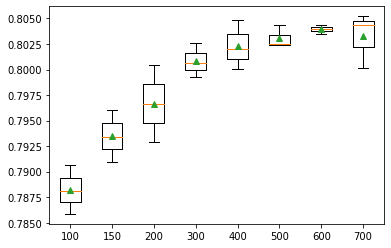

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding the optimum sample size

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models = {}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():

    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Samples(0.1)---Accuracy( 0.79175)
Samples(0.2)---Accuracy( 0.79953)
Samples(0.3)---Accuracy( 0.80181)
Samples(0.4)---Accuracy( 0.80376)
Samples(0.5)---Accuracy( 0.80479)
Samples(0.6)---Accuracy( 0.80563)
Samples(0.7)---Accuracy( 0.80410)
Samples(0.8)---Accuracy( 0.80552)
Samples(0.9)---Accuracy( 0.80597)
Samples(1.0)---Accuracy( 0.80556)


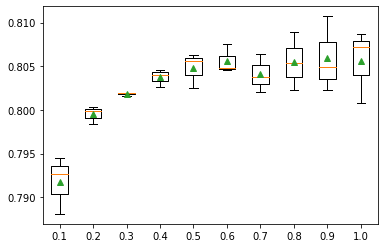

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding optimum learning rate 

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = i, # range [0,1], typically=0.01-0.2 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models ={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Learning Rate(0.1000)---Accuracy( 0.80440)
Learning Rate(0.1500)---Accuracy( 0.80183)
Learning Rate(0.2000)---Accuracy( 0.80123)
Learning Rate(0.2500)---Accuracy( 0.80069)
Learning Rate(0.3000)---Accuracy( 0.79704)
Learning Rate(0.3500)---Accuracy( 0.79802)
Learning Rate(0.4000)---Accuracy( 0.79757)
Learning Rate(0.4500)---Accuracy( 0.79544)
Learning Rate(0.5000)---Accuracy( 0.79633)


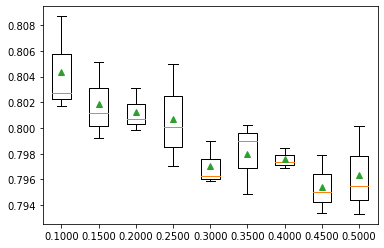

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.5- Finding the optimum depth 

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,13):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = i, # the larger the more prone to overfit, range 3-10 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Decision tree depth (1)---Accuracy( 0.73371)
Decision tree depth (2)---Accuracy( 0.75653)
Decision tree depth (3)---Accuracy( 0.77402)
Decision tree depth (4)---Accuracy( 0.78739)
Decision tree depth (5)---Accuracy( 0.79611)
Decision tree depth (6)---Accuracy( 0.79865)
Decision tree depth (7)---Accuracy( 0.80415)
Decision tree depth (8)---Accuracy( 0.80397)
Decision tree depth (9)---Accuracy( 0.80462)
Decision tree depth (10)---Accuracy( 0.80572)
Decision tree depth (11)---Accuracy( 0.80436)
Decision tree depth (12)---Accuracy( 0.80316)


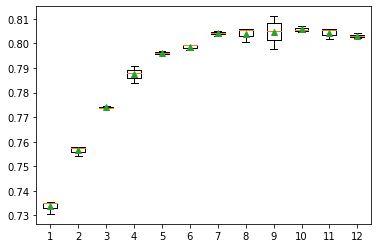

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.6- Finding the optimum colsample_bytree

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bylevel = i,
                            colsample_bynode = i,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Portion of Features Selected - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

Portion of Features Selected - colsample_by (0.0)---Accuracy( 0.76839)
Portion of Features Selected - colsample_by (0.1)---Accuracy( 0.79055)
Portion of Features Selected - colsample_by (0.2)---Accuracy( 0.79611)
Portion of Features Selected - colsample_by (0.30000000000000004)---Accuracy( 0.79622)
Portion of Features Selected - colsample_by (0.4)---Accuracy( 0.80168)
Portion of Features Selected - colsample_by (0.5)---Accuracy( 0.80524)
Portion of Features Selected - colsample_by (0.6000000000000001)---Accuracy( 0.80404)
Portion of Features Selected - colsample_by (0.7000000000000001)---Accuracy( 0.80337)
Portion of Features Selected - colsample_by (0.8)---Accuracy( 0.80324)
Portion of Features Selected - colsample_by (0.9)---Accuracy( 0.80206)
Portion of Features Selected - colsample_by (1.0)---Accuracy( 0.80236)


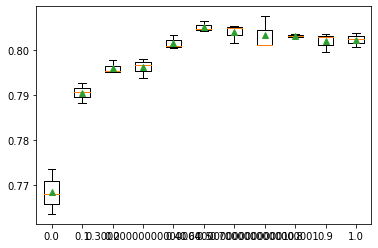

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.7- Finding the optimum scale_pos_weight

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0.1, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = i, #[default=1] #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('scale_pos_weight - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

scale_pos_weight - colsample_by (0.1)---Accuracy( 0.80395)
scale_pos_weight - colsample_by (0.2)---Accuracy( 0.80309)
scale_pos_weight - colsample_by (0.30000000000000004)---Accuracy( 0.80305)
scale_pos_weight - colsample_by (0.4)---Accuracy( 0.80374)
scale_pos_weight - colsample_by (0.5)---Accuracy( 0.80271)
scale_pos_weight - colsample_by (0.6)---Accuracy( 0.80397)
scale_pos_weight - colsample_by (0.7000000000000001)---Accuracy( 0.80116)
scale_pos_weight - colsample_by (0.8)---Accuracy( 0.80385)
scale_pos_weight - colsample_by (0.9)---Accuracy( 0.80370)
scale_pos_weight - colsample_by (1.0)---Accuracy( 0.80383)


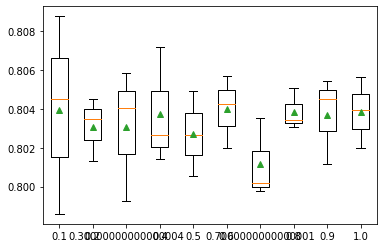

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

###4.3.2- GridSearchCV for Hyperparameter tuning of XGBoost

In [ ]:
# defiing the model
model = XGBClassifier( 
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            scale_pos_weight = 0.6, #[default=1] 
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = [400, 500, 600, 700]

# values for learning rate
grid['learning_rate'] = [0.08, 0.09, 0.1]

# values for the sampel
grid['subsample'] = [0.3, 0.4, 0.5, 0.6]

# values for teh depth of tree
grid['max_depth'] = [6, 7, 8, 9]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# storing the values
grid_result = grid_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###f
https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [ ]:
    params = {'max_depth': [3, 6, 10],
              #'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              #'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              # 'n_estimators': [100, 250, 500, 750],
              }

In [ ]:
    xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=5,
                             n_jobs=4,
                             verbose=3)

In [ ]:
    clf.fit(x_train, y_train)

    best_combination = clf.best_params_
    print("Best hyperparameter combination: ", best_combination)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.

min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.

gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.

subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.

scale_pos_weight = 1: Because of high class imbalance.

Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

###4.3.3 Fitting the Optimum Model

In [ ]:
xgboost_clf = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [ ]:
xgboost_clf.fit(x_train,y_train)

XGBClassifier(colsample_bytree=0.5, max_depth=8, min_child_weight=0,
              n_estimators=600, objective='multi:softprob', random_state=17,
              scale_pos_weight=0.5, subsample=0.6)

In [ ]:
xgboost_preds = xgboost_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3226
           1       0.57      0.32      0.41       432
           2       0.85      0.79      0.82      2282

    accuracy                           0.82      5940
   macro avg       0.75      0.67      0.70      5940
weighted avg       0.81      0.82      0.81      5940



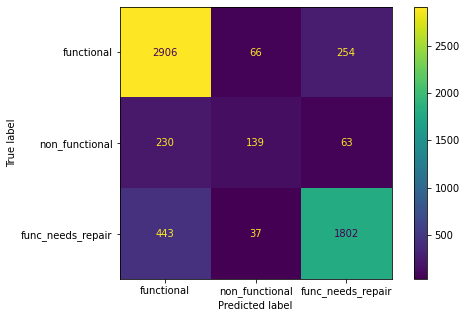

In [ ]:
print(classification_report(y_valid, xgboost_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, xgboost_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
# importing modules
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# <a href="https://techfor-today.com/sklearn-confusion-matrix-in-machine-learning/">confusion matrix</a> plotting
cm = confusion_matrix(y_valid,xgboost_preds, labels=xgboost_clf.classes_)
# labelling
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_clf.classes_)
disp.plot()
plt.show()

##4.4- LightGBM
Light Gradient Boosting Machine. It is a supervised boosting algorithm that works in a similar way as the XGBoost algorithm does but with some advanced features that makes it more powerful and fast.

Don’t need to handle the NULL value explicitly in the data preprocessing step while using the LightGBM algorithm as it also handles NULL values automatically.

It uses a histogram-based algorithm for the splitting of nodes and Gradient-Based One Side Sampling (GOSS) for the sampling.

###4.4.1- Hyperparameter tuning of LightGBM

####4.4.1.1- Finding the optimum number of iterations in LightGBM

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    r_square = cross_val_score(model, Input, Ouput, scoring='r2', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return r_square

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = LGBMClassifier(n_estimators=i)
    
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    R_square = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(R_square)
    names.append(name)
    
    
    # printing the accuracy score
    print('Iterations (%s)---R-square( %.5f)' % (name, np.mean(R_square)))

Iterations (10)---R-square( 0.06233)
Iterations (50)---R-square( 0.21608)
Iterations (100)---R-square( 0.26569)
Iterations (500)---R-square( 0.34298)


####4.4.1.2- Finding the optimum number of Features in LightGBM

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    models = dict()
    
    # explore features numbers from 1-5
    for i in range(1,6):
        
#         appending the models
        models[str(i)] = LGBMClassifier(max_features=i)
    
#     returining the models
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('---->Features(%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Finding the optimum sample size in LightGBM

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = LGBMClassifier(subsample=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Samples(%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Finding the optimum learning rate in LightGBM

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = LGBMClassifier(learning_rate=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Learning Rate(%s)---R Square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.4- Finding the optimum depth of tree in LightGBM

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,12):
        
#         appending the models
        models[str(i)] = LGBMClassifier(max_depth=i)
        
#   returining the model
    return models

In [ ]:
# calling the function
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    R_square = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(R_square)
    names.append(name)
    
#     printing the results
    print('Decision tree depth (%s)---R_square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.4.2 -GridSearchCV in LightGBM to get optimum values for parameters

In [ ]:
# defiing the model
model = LGBMClassifier()


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]

# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]

# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)


# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='r2')

# storing the values
grid_result = grid_search.fit(x_train, y_train)


# printing the best parameters
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

##4.2- Random Forest 

####Fit Random Forest Model and Hyperparameter Tuning 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [ ]:
random_forest_hyperparam = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        n_jobs = -1,
        random_state = 42,
        class_weight = 'balanced'
    ),
    param_distributions = {
        'n_estimators' : [100, 500, 1000],
    },
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    random_state = 42,
    return_train_score = True,
    n_iter = 25
).fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=25. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan nan nan]
  category=UserWarning,


In [ ]:
random_forest_hyperparam.best_params_

{'n_estimators': 100}

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators = 100,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
).fit(x_train, y_train)

####Perform Prediction and Display Results for Random Forest

In [ ]:
rf_preds = rf_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.81      0.90      0.86      3226
           1       0.56      0.34      0.42       432
           2       0.86      0.79      0.82      2282

    accuracy                           0.82      5940
   macro avg       0.75      0.68      0.70      5940
weighted avg       0.81      0.82      0.81      5940



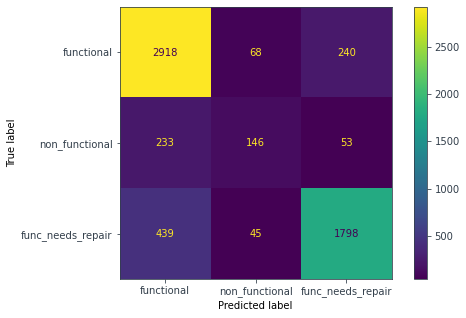

In [ ]:
print(classification_report(y_valid, rf_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, rf_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
rf_table = PrettyTable()
rf_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

rf_preds = rf_clf.predict(x_valid)

rf_table.add_row([
    'Random Forest',
    accuracy_score(y_true = y_valid, y_pred = rf_preds),
    f1_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = rf_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = rf_preds, average='weighted')
])

print(rf_table)

+---------------+--------------------+--------------------+--------------------+--------------------+
|   Model Name  |      Accuracy      |      F1-Score      |     Precision      |       Recall       |
+---------------+--------------------+--------------------+--------------------+--------------------+
| Random Forest | 0.8185185185185185 | 0.8116586035888954 | 0.8127766699102136 | 0.8185185185185185 |
+---------------+--------------------+--------------------+--------------------+--------------------+


####Feature Importance - Random Forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


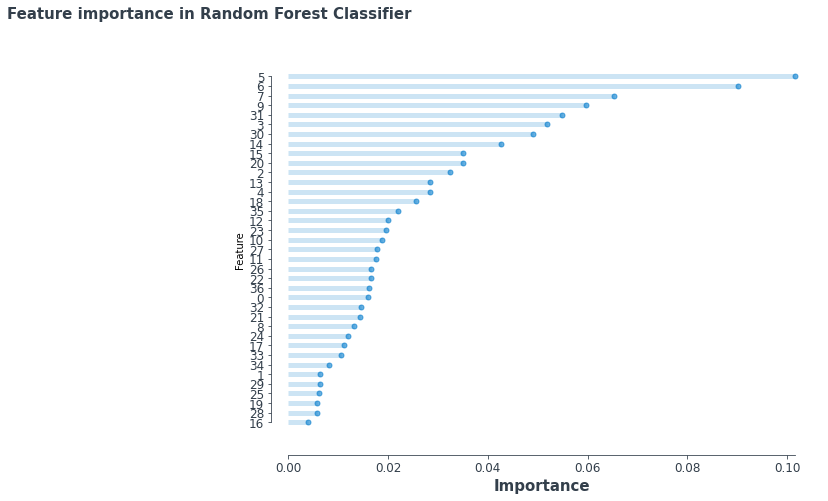

In [ ]:

pretty_importances_plot(
    rf_clf.feature_importances_, 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Random Forest Classifier'
)

##4.3-  Gradient Boosted Decision Trees

In [ ]:
gbdt_clf = XGBClassifier(
    n_estimators = 500,
    learning_rate=0.01,
    max_depth = 5,
    min_child_weight=10,
    gamma=0.4,
    nthread=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    scale_pos_weight=3,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
).fit(x_train, y_train, verbose=1)

In [ ]:
gbdt_hyperparam = RandomizedSearchCV(
    estimator = XGBClassifier(
                learning_rate=0.01,
                max_depth = 5,
                min_child_weight=10,
                gamma=0.4,
                nthread=4,
                subsample=0.8,
                colsample_bytree=0.8,
                objective='multi:softmax',
                scale_pos_weight=3,
                verbosity = 1,
                n_jobs = -1,
                random_state = 42,
    ),
    param_distributions = [100, 500, 1000, 2000],
    n_jobs = -1,
    verbose = 3,
    random_state = 42
)

In [ ]:
gbdt_pred = gbdt_clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      3226
           1       0.60      0.11      0.19       432
           2       0.85      0.59      0.70      2282

    accuracy                           0.75      5940
   macro avg       0.72      0.55      0.56      5940
weighted avg       0.76      0.75      0.72      5940



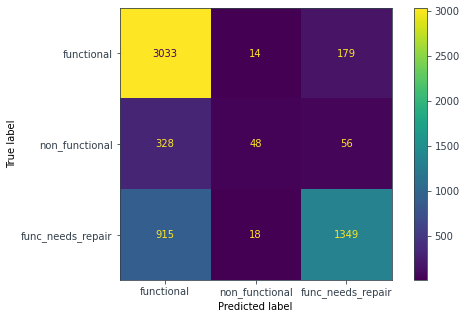

In [ ]:
print(classification_report(y_valid, gbdt_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, gbdt_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
gbdt_table = PrettyTable()
gbdt_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

gbdt_pred = gbdt_clf.predict(x_valid)

gbdt_table.add_row([
    'GBDT',
    accuracy_score(y_true = y_valid, y_pred = gbdt_pred),
    f1_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    precision_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    recall_score(y_true = y_valid, y_pred = gbdt_pred, average='weighted'),
    # log_loss(y_true = y_vali, y_pred = gbdt_pred, average='weighted')
])

print(gbdt_table)

+------------+--------------------+--------------------+--------------------+--------------------+
| Model Name |      Accuracy      |      F1-Score      |     Precision      |       Recall       |
+------------+--------------------+--------------------+--------------------+--------------------+
|    GBDT    | 0.7457912457912458 | 0.7208843356050798 | 0.7560391506046725 | 0.7457912457912458 |
+------------+--------------------+--------------------+--------------------+--------------------+


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


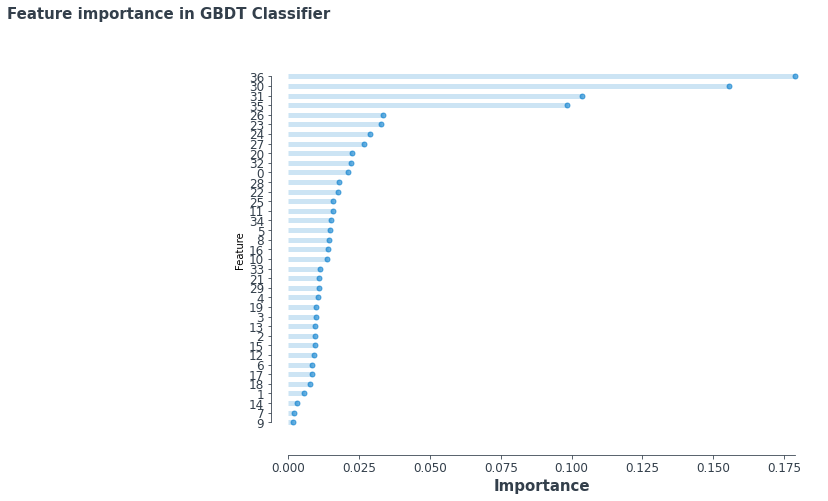

In [ ]:
#feature importances

pretty_importances_plot(
    gbdt_clf.feature_importances_, 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in GBDT Classifier'
)

##4.5- CatBoostClassifier